In [12]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from keras.models import load_model
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from class_names import LetterList
import natsort
import cv2
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed

In [13]:
# Load the saved model
model = load_model('sign_2.h5')
segment_model = load_model('segment.h5')
class_names = LetterList().getList()

In [14]:
data_dir = os.path.join(os.path.abspath(os.pardir), "ASL_Alphabet_Dataset", "asl_alphabet_train")

image_size = 100
num_classes = 29

def process_image(image_filename, folder_dir, folder_name, label):
    img_file = cv2.imread(os.path.join(folder_dir, folder_name, image_filename), cv2.IMREAD_GRAYSCALE)
    if img_file is not None:
        img_resized = cv2.resize(img_file, (image_size, image_size))
        img_normalized = img_resized / 255.0
        final_img = img_normalized.reshape((-1, image_size, image_size, 1))
        return final_img, label
    else:
        return None

def get_data(folder_dir):
    X = np.empty((223075, image_size, image_size, 1), dtype=np.float32)
    y = np.empty((223075), dtype=np.int32)

    counter = 0
    folders = natsort.natsorted(os.listdir(folder_dir))
    for index, folder_name in enumerate(folders):
        if not folder_name.startswith("."):
            label = index
            print(f"Processing folder: {folder_name}")
            images = natsort.natsorted(os.listdir(os.path.join(folder_dir, folder_name)))

            results = Parallel(n_jobs=-1)(
                delayed(process_image)(image_filename, folder_dir, folder_name, label) for image_filename in images
            )

            for res in results:
                if res is not None:
                    X[counter], y[counter] = res
                    counter += 1
    return X[:counter], y[:counter]

print("Getting images from folders...\n")
X, y = get_data(data_dir)

print("\nImages successfully imported...\n")

label_dict = LetterList.getList()

print("Splitting data into train, validation, and test sets...\n")

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    shuffle=True,
    random_state=50,
    stratify=y,
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    train_size=0.875,
    shuffle=True,
    random_state=50,
    stratify=y_train,
)

Getting images from folders...

Processing folder: A
Processing folder: B
Processing folder: C
Processing folder: D
Processing folder: E
Processing folder: F
Processing folder: G
Processing folder: H
Processing folder: I
Processing folder: J
Processing folder: K
Processing folder: L
Processing folder: M
Processing folder: N
Processing folder: O
Processing folder: P
Processing folder: Q
Processing folder: R
Processing folder: S
Processing folder: T
Processing folder: U
Processing folder: V
Processing folder: W
Processing folder: X
Processing folder: Y
Processing folder: Z
Processing folder: del
Processing folder: nothing
Processing folder: space

Images successfully imported...

Splitting data into train, validation, and test sets...



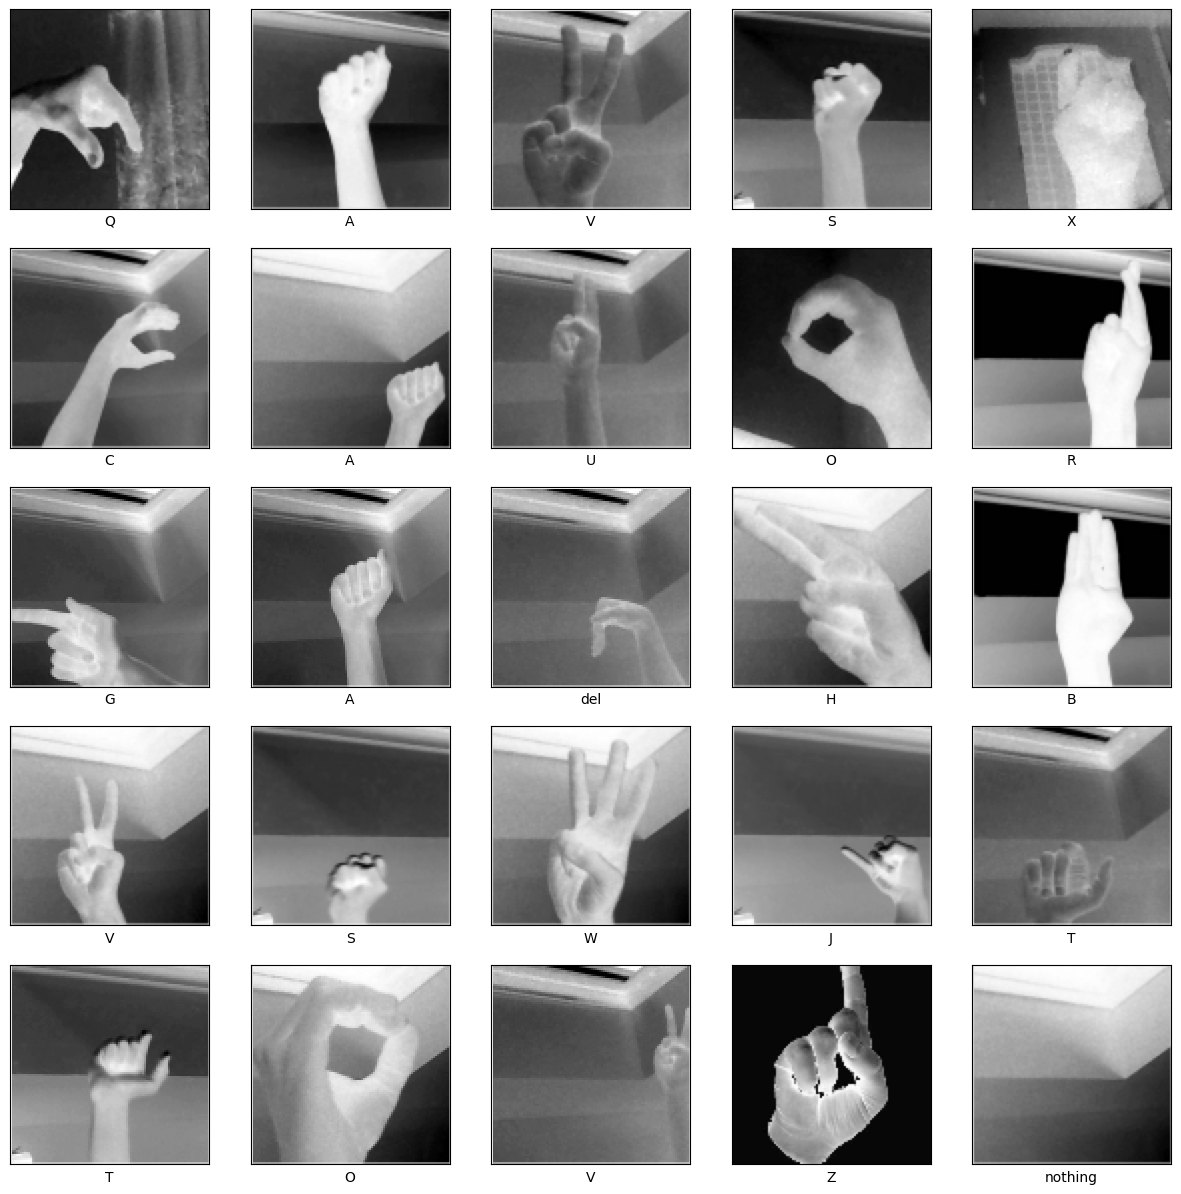

In [5]:
# plot the first 25 images in the test set
ax , fig = plt.subplots(5, 5, figsize=(15, 15))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i].reshape(100, 100), cmap=plt.cm.binary)
    plt.xlabel(label_dict[y_train[i]])
    plt.title("Training Images Samples")

In [6]:
# Make predictions on the test set
predictions = model.predict(X_test)
pred_classes = np.argmax(predictions, axis=1)

1395/1395 [==============================] - 8s 3ms/step


In [7]:
# Calculate the classification report
report = classification_report(y_test, pred_classes)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1692
           1       0.99      0.99      0.99      1662
           2       1.00      0.99      0.99      1629
           3       0.99      0.99      0.99      1526
           4       0.98      0.99      0.98      1549
           5       0.99      0.99      0.99      1606
           6       1.00      0.97      0.98      1569
           7       0.98      1.00      0.99      1581
           8       0.98      0.99      0.99      1591
           9       1.00      1.00      1.00      1500
          10       0.99      0.99      0.99      1575
          11       0.99      1.00      1.00      1588
          12       0.99      0.98      0.99      1580
          13       0.99      0.99      0.99      1586
          14       0.99      0.99      0.99      1628
          15       1.00      1.00      1.00      1520
          16       0.99      1.00      1.00      1591
    

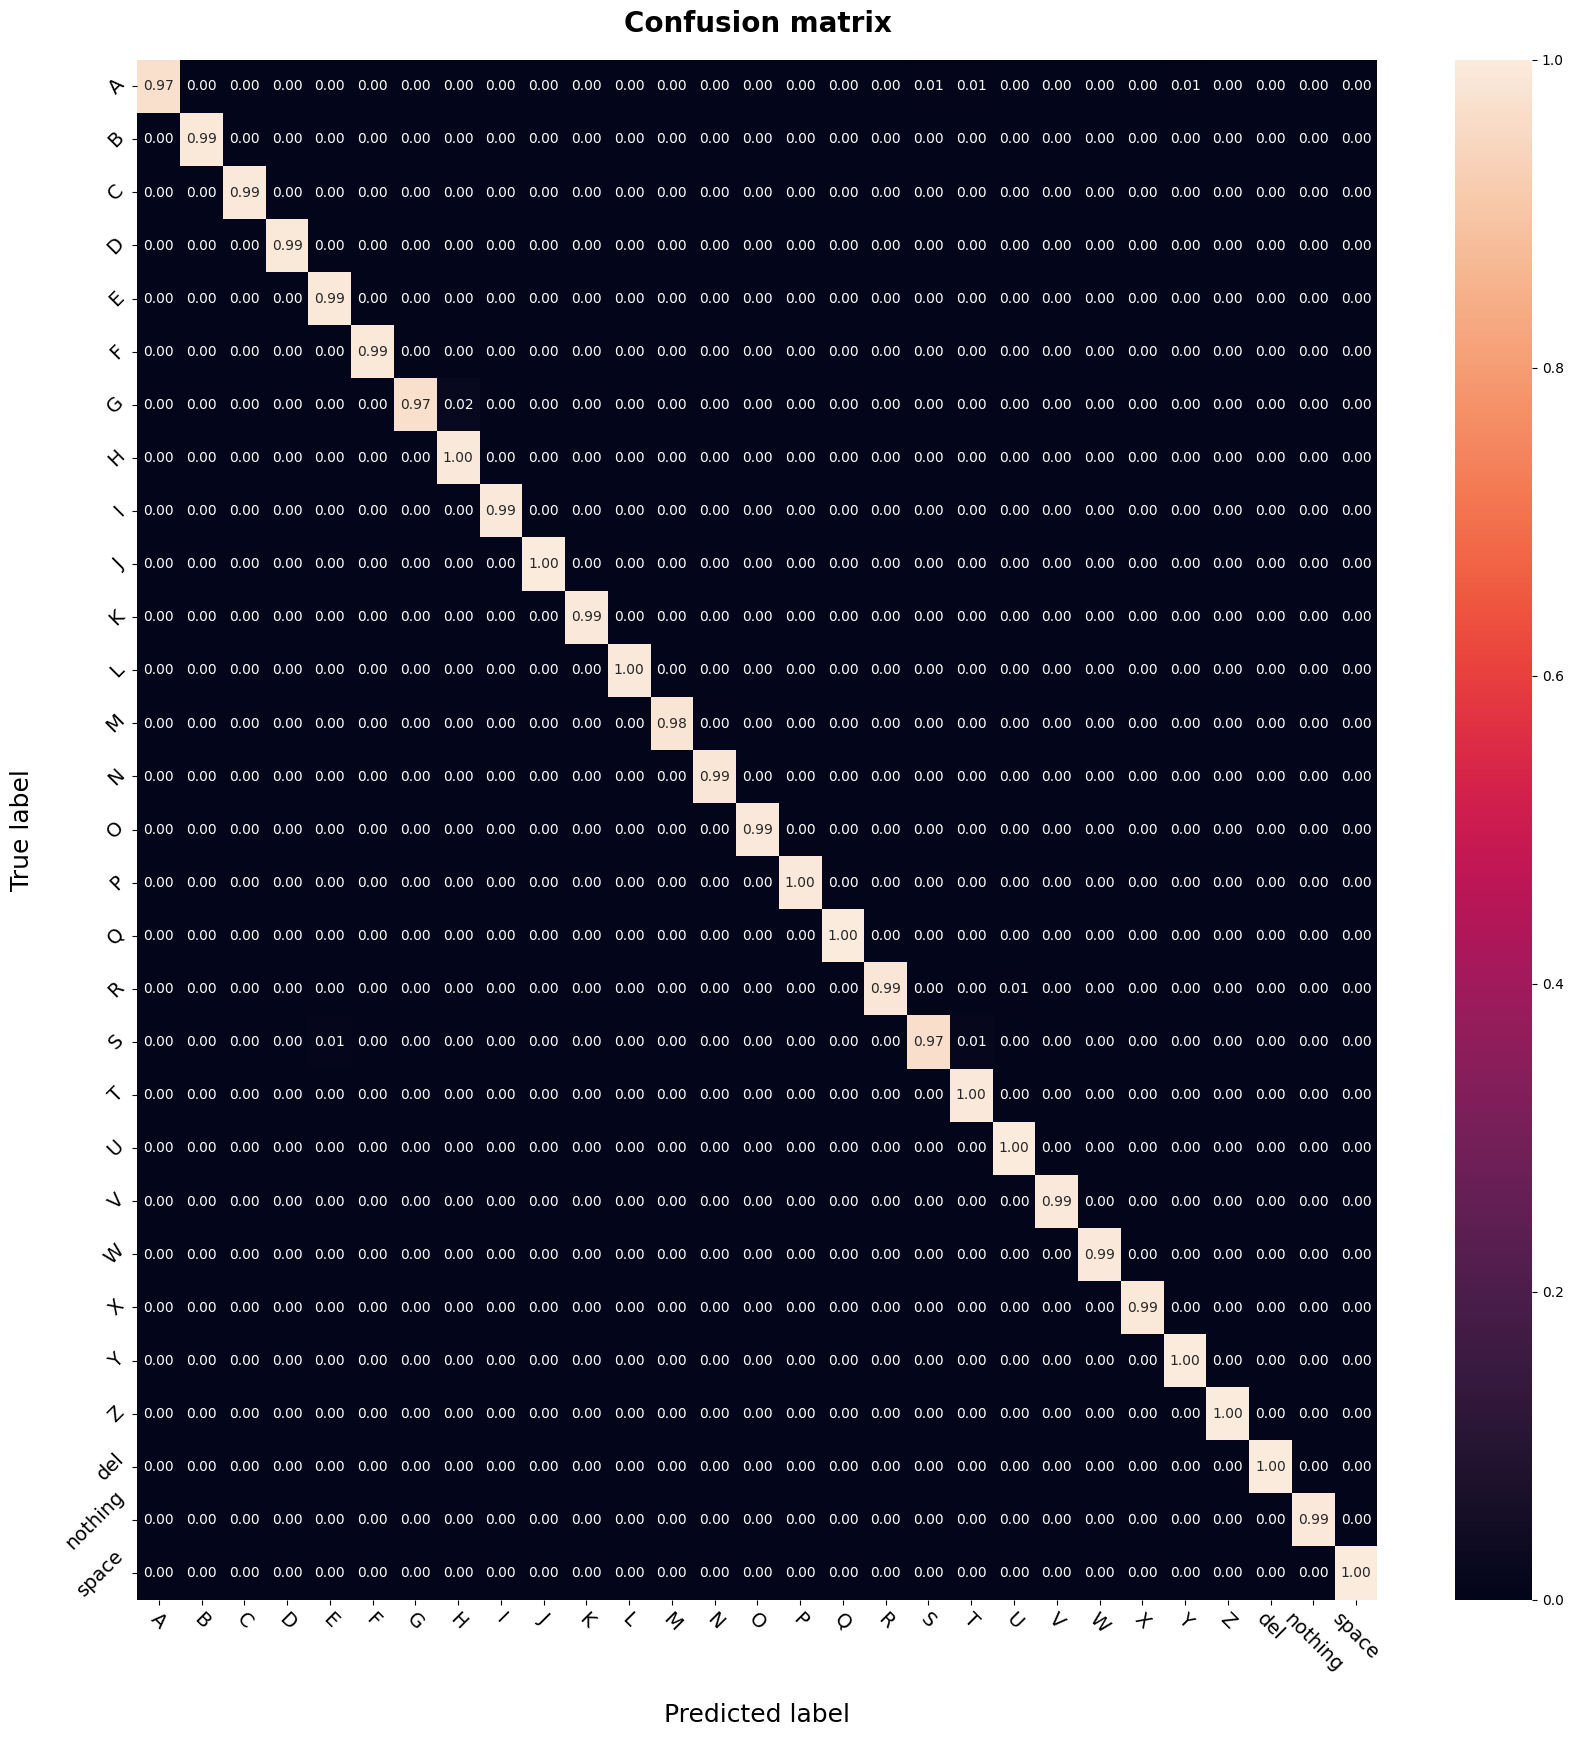

In [8]:
# Generate confusion matrix
cm = confusion_matrix(y_test, pred_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(20, 20))
sns.heatmap(cm, 
            annot=True, 
            fmt='.2f', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.ylabel('True label', labelpad=20, fontsize=18)
plt.xlabel('Predicted label', labelpad=20, fontsize=18)
plt.title('Confusion matrix', fontsize=20, fontweight='bold', pad=20)
plt.xticks(rotation=-45, fontsize=14)
plt.yticks(rotation=45, fontsize=14)
plt.show()

In [15]:
# Also evaluate the model's accuracy on the test data
y_one_hot = to_categorical(y_test)

test_loss, test_accuracy = model.evaluate(X_test, y_one_hot, verbose=0)
print("Test Loss: ", test_loss)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Loss:  0.0395372174680233
Test Accuracy: 99.10%
